# SIV PROJECT - CLASSIFICATION OF SHIP FROM SAR IMAGES

## PRESENTATION

Our project consists in the development of a ship detection system for SAR images. For this purpose we use a dataset of nearly 40,000 images and a popular object detection algorithm: YOLOv8. Before the training phase we pre-process the images to improve their quality, testing different state of the art filter for SAR images.

## PRE-PROCESSING PHASE


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import random
import glob
import zipfile

Here we define some utility functions that will be used in the notebook.

In [2]:
from skimage import img_as_float

# Show multiple images
def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        cmap='gray' if len(img.shape) == 2 else None
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(label)

# function to take a random file from the folder and applying canny transformation
def get_random_jpg_file(jpg_files):
    if not jpg_files:
        print("No jpg files found in the folder.")
        return None

    random_jpg = random.choice(jpg_files)

    return os.path.join(random_jpg)

# function to unzip a directory
def unzip_dir(dir):
    if not os.path.exists(dir):    
        with zipfile.ZipFile(f'{dir[:-1]}.zip', 'r') as zip_ref:
            zip_ref.extractall('./')
    else:
        print("The directory already exists.")

## SAR Images Dataset

We have a dataset of 39729 SAR images, each one of size 256 x 256.

The directory already exists.
The dataset contains 39729 images.


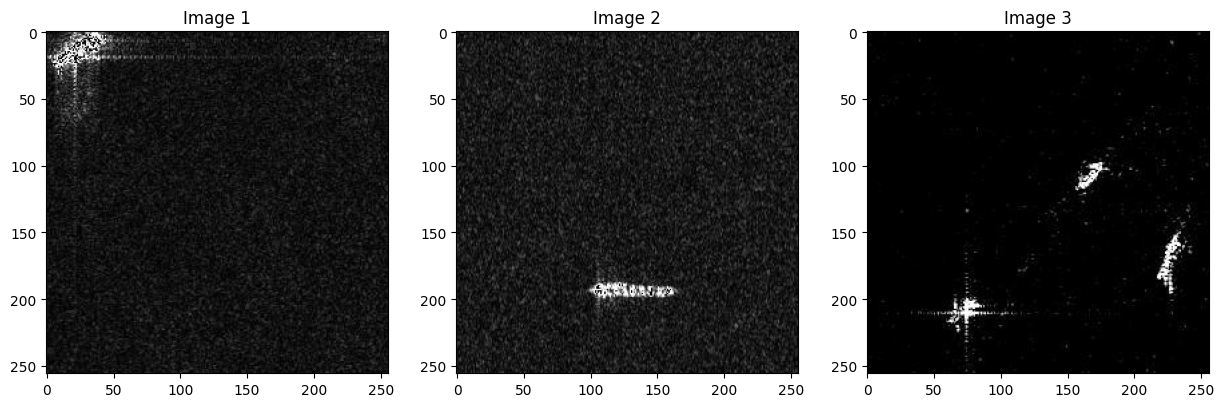

In [3]:
BASE_DIR = './ship_dataset_v0/'

unzip_dir(BASE_DIR)

# Replace 'path/to/directory' with the directory path where your .jpg files are located
jpg_files = glob.glob(BASE_DIR +'*.jpg')
print(f'The dataset contains {len(jpg_files)} images.')

# display n images from jpg_files randomly or not
def display_images(jpg_files, n_times, rand=True):
    if not jpg_files:
        print("There are not images to display.")
        return
    
    images = []
    titles = []

    for i in range(n_times):
        if rand:
            img = get_random_jpg_file(jpg_files)
        else:
            img = jpg_files[i]
        if isinstance(img, str):
            img = cv2.imread(img)
        
        title = f'Image {i+1}'
        images.append(img)
        titles.append(title)
        
    imshow_all(*images, titles=titles)

display_images(jpg_files, 3)

This preprocessing phase focuses on removing noise from images to give to our detection model better interpretable inputs.

The bigger problem with SAR images is the ***speckle noise***, a type of multiplicative noise which appears due to the variation in the backscatter from non-homogeneous cells, which gives a grainy appearance to SAR images.

In the following images, it is possible to see how this noise impacts on the visualization. Removing it will help us in better separating ships from the sea or the ground.

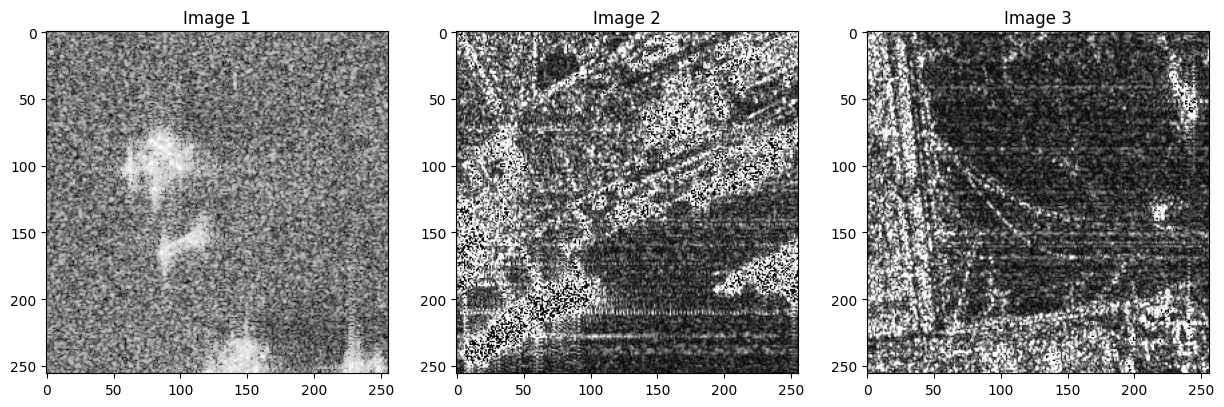

In [4]:
images = [
    BASE_DIR + 'Gao_ship_hh_02017012730010509' + '.jpg',
    BASE_DIR + 'Gao_ship_hh_02017030968030704' + '.jpg',
    BASE_DIR + 'Gao_ship_vv_0201611300001019012' + '.jpg'
]

display_images(images, len(images), rand=False)

We now take a random image as example to test different image processing techniques and try to improve the quality of the images.
Since the color is not relevant in the image, we convert it to grayscale to reduce the channels from 3 to 1 for an easier computation.

Image file name: ./ship_dataset_v0\Sen_ship_hv_02017112701034048.jpg
Each image is 256 rows x 256 cols of pixels
The original image has 3 channels: (256, 256, 3)
The grayscale version of the image has only 1 channel: (256, 256)

 ./ship_dataset_v0\Sen_ship_hv_02017112701034048.txt
Contents of the file:
0 0.3046875 0.595703125 0.140625 0.07421875

The ships in the file are 1


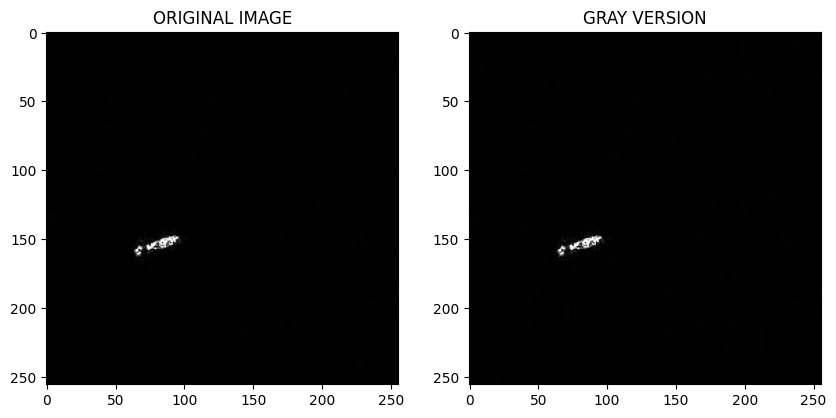

In [5]:
file_jpg = get_random_jpg_file(jpg_files)
print(f'Image file name: {file_jpg}')
img = cv2.imread(file_jpg)
print(f'Each image is {img.shape[0]} rows x {img.shape[1]} cols of pixels')
print(f'The original image has 3 channels: {img.shape}')

# convert the image to grayscale to remove useless channels (from 3 to 1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(f'The grayscale version of the image has only 1 channel: {gray.shape}')

# analize the text file
file_txt = file_jpg[:-3] + 'txt'
print('\n', file_txt)
ships_cnt = 0
with open(file_txt, 'r') as file:
    file_content = file.read()
    print("Contents of the file:")
    print(file_content)
    ships_cnt = len(file_content.splitlines())
    print(f'The ships in the file are {ships_cnt}')

imshow_all(img, gray, titles=["ORIGINAL IMAGE", "GRAY VERSION"])

Here we show the histogram of the image, so we can analize the number of pixels for the different levels of tonality.

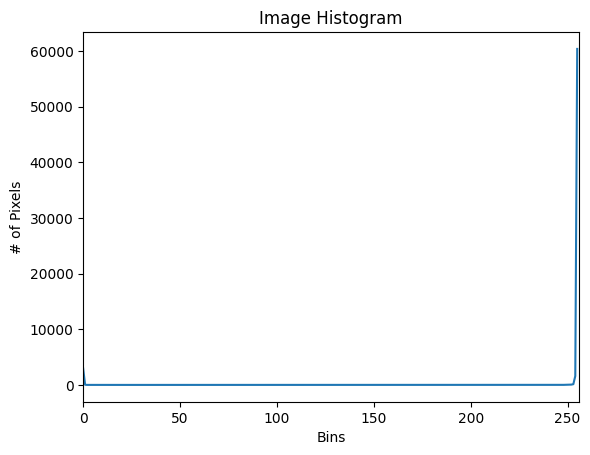

In [6]:
# function to compute and plot the histogram of a grayscale image
def grayscale_histogram(img, title=""):
    img = np.uint8(img * 255)
    histogram = cv2.calcHist([img], [0], None, [256], [0, 256])

    plt.figure()
    plt.title(title)
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(histogram)
    plt.xlim([0, 256])
    plt.show()

grayscale_histogram(gray, title="Image Histogram")

## SAR Images Processing Techniques

## Denoising

The pre-processing techniques of SAR images have been broadly put under the following two categories:

* ***Spatial Filtering:*** this filters involve a convolution filtering in the spatial domain, using a kernel that is moved and applied to each pixel of the image. Three of the filters that we use are spatial filters: non-local means filter, Lee filter, and Frost filter.

* ***Frequency Domain Filtering:*** the remaining denoising approach is the Wavelet filter, that is a particular frequency domain technique, a familiy of filters that trasform images in frequency domain.

### Non-Local Means Filter

The non-local means filter replaces the value of a pixel by an average of a selection of other pixels values: small patches centered on the other pixels are compared to the patch centered on the pixel of interest, and the average is performed only for pixels that have patches close to the current patch.

We try the Non-Local Means Filter using 2 different patch size. A lowest patch size keep details while a higher one remove more noise. We plot both results to compare them and we choose to keep an higher patch distance, since details are not so important as the noise removal in our situation.

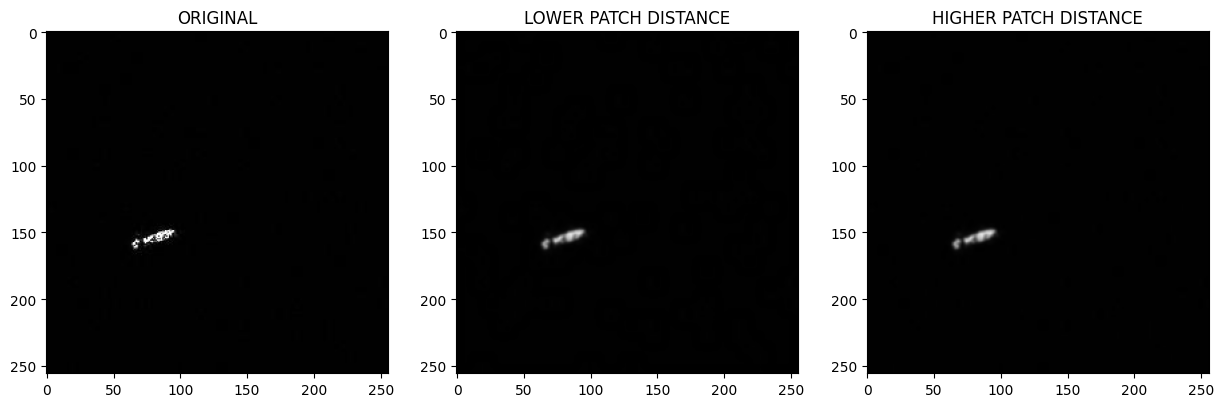

In [7]:
from skimage.restoration import denoise_nl_means, estimate_sigma

def nl_means_filter(img, k_size=5, patch_distance=6):
    sigma_est = np.mean(estimate_sigma(img, channel_axis=None))
    nl_means = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=patch_distance, channel_axis=None)

    # apply Gaussian blur to remove non speckle noise
    nl_means = np.uint8(nl_means * 255)
    blurred_img = cv2.GaussianBlur(nl_means, (k_size, k_size), 0)

    return blurred_img

img = gray.astype(np.float64) / 255.0

# Non-Local Means Denoising technique with lower patch distance
nl_means_img = nl_means_filter(img, patch_distance=3)
# Non-Local Means Denoising technique with higher patch distance
nl_means_img_lower = nl_means_filter(img)


imshow_all(img, nl_means_img_lower, nl_means_img, titles=["ORIGINAL", "LOWER PATCH DISTANCE", "HIGHER PATCH DISTANCE"])

### Wavelet Filter

Wavelet denoising relies on the wavelet representation of the image and there are two methods, in the scikit-image filter, for wavelet coefficient tresholding selection:

* **VisuShrink:** this approach employs a single, universal threshold to all wavelet detail coefficients.
* **BayesShrink:** this is an adaptive approach to wavelet soft thresholding where a unique threshold is estimated for each wavelet subband.

Since the BayesShrink is adaptive we notice a better processing using this method against the simpler VisuShrink approach.

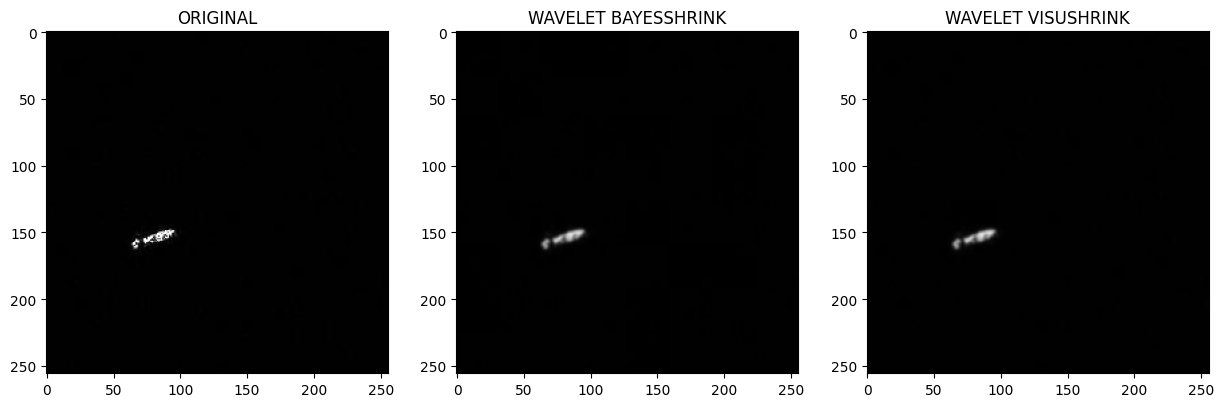

In [8]:
from skimage.restoration import denoise_wavelet

def wavelet_filter(img, k_size=5, method='BayesShrink'):
    if method == 'BayesShrink':
        res_img = denoise_wavelet(img, channel_axis=None, method=method, mode='soft', rescale_sigma=True)
    elif method == 'VisuShrink':
        sigma_est = estimate_sigma(img, channel_axis=None, average_sigmas=True)
        res_img = denoise_wavelet(img, channel_axis=None, method='VisuShrink', mode='soft', 
                                    sigma=sigma_est, rescale_sigma=True)
    else:
        print("The method given is not a valid one.")
        return

    # apply Gaussian blur to remove non speckle noise
    res_img = np.uint8(res_img * 255)
    blurred_img = cv2.GaussianBlur(res_img, (k_size, k_size), 0)

    return blurred_img

# Wavelet Denoising technique using the Bayes Shrink method
wavelet_img = wavelet_filter(img)
# Wavelet Denoising technique using the Visu Shrink method
wavelet_img_visushrink = wavelet_filter(img, method='VisuShrink')

imshow_all(img, wavelet_img, wavelet_img_visushrink, titles=["ORIGINAL", "WAVELET BAYESSHRINK", "WAVELET VISUSHRINK"])

### Lee Filter

The Lee filter is very efficient in removing speckle noise from homogeneous regions of images. It is instead not so efficient in preserving details or edges, but since in our problem this is not a crucial point we can apply it. Its mathematical description is as follows:

$$Y_{ij} = \overline{K} + W*(C - \overline{K})$$

Where $Y_{ij}$ is the resulting filtered image, $\overline{K}$ is the mean of the kernel, $C$ is the center element in the kernel, and $W$ is the weighting function computed as:

$$W = \frac{\sigma_{k}^2}{(\sigma_{k}^2 + \sigma^2)}$$

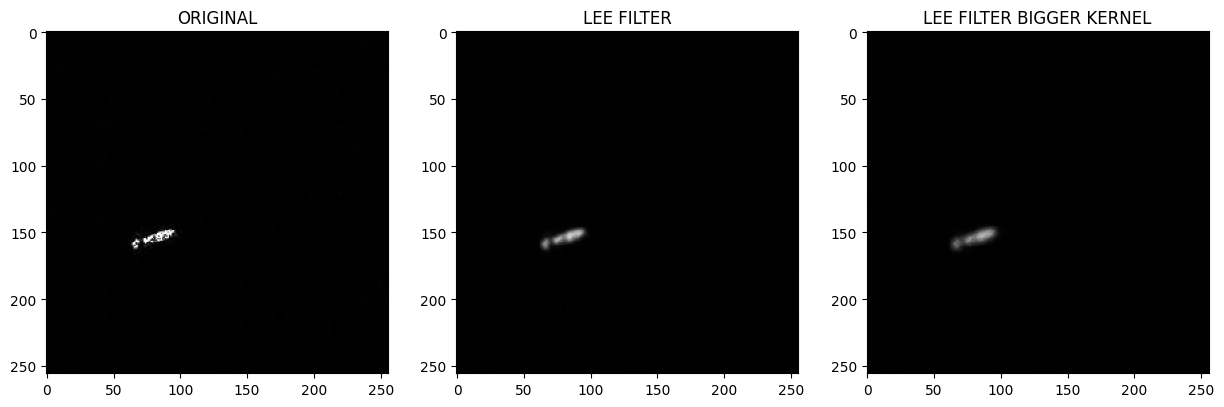

In [9]:
# smaller k ==> less smoothing and details preservation
# greater k ==> more smoothing and less details preservation
def lee_filter(img, window_size=5, k=1.0):

    radius = window_size // 2
    padded_img = np.pad(img, radius, mode='reflect')
    filtered_img = np.zeros_like(img)

    for i in range(radius, padded_img.shape[0] - radius):
        for j in range(radius, padded_img.shape[1] - radius):
            local_window = padded_img[i - radius:i + radius + 1, j - radius:j + radius + 1]
            local_mean = np.mean(local_window)
            local_var = np.var(local_window)
            weight = local_var / (local_var + k**2)

            filtered_img[i - radius, j - radius] = local_mean + weight * (img[i - radius, j - radius] - local_mean)
            
    filtered_img = np.uint8(filtered_img * 255)
    return filtered_img

lee_img = lee_filter(img)
lee_img2 = lee_filter(img, window_size=7)

imshow_all(img, lee_img, lee_img2, titles=["ORIGINAL", "LEE FILTER", "LEE FILTER BIGGER KERNEL"])

### Frost Filter

The Frost filter is used primarily to suppress speckle noise: it smooths image data without removing edges or sharp features in the images while minimizing the loss of radiometric and textural information. Here we show its mathematical formulation:

$$Y = \frac{\sum{(x * W)}}{\sum{W}}$$

Where $Y$ is the filtered pixel value in the local window, $x$ is the pixel value in the local window, and W is the weight for each pixel in the local window defined as follow:

$$W = e^{(-B * S)}$$

Where $B = D * \left(\frac{Varx}{meanx*meanx}\right)$ and S is the matrix of the distances between the window pixels and the center one.

C:\Users\edoar\AppData\Local\Temp\ipykernel_23052\3569998842.py:18: RuntimeWarning: invalid value encountered in double_scalars
  weights = np.exp((-dumping_factor * (local_var / local_mean**2)) * distances)


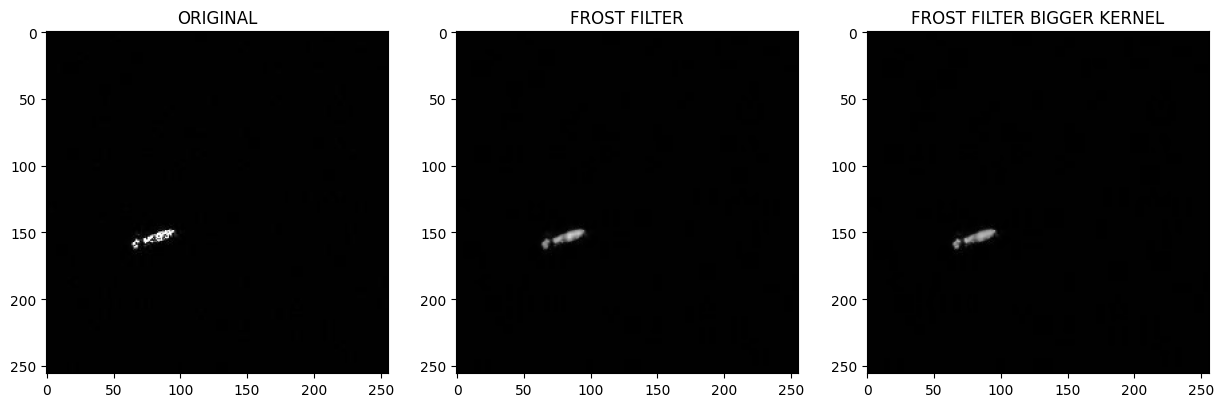

In [12]:
# smaller dumping_factor ==> less smoothing and details preservation
# greater dumping_factor ==> more smoothing and less details preservation
def frost_filter(img, window_size=5, dumping_factor=1.0):
    
    radius = window_size // 2
    padded_img = np.pad(img, radius, mode='reflect')
    filtered_img = np.zeros_like(img)

    for i in range(radius, padded_img.shape[0] - radius):
        for j in range(radius, padded_img.shape[1] - radius):

            local_window = padded_img[i - radius:i + radius + 1, j - radius:j + radius + 1]

            local_mean = np.mean(local_window)
            local_var = np.var(local_window)

            distances = np.sqrt((np.arange(window_size) - radius)[:, None]**2 + (np.arange(window_size) - radius)**2)
            weights = np.exp((-dumping_factor * (local_var / local_mean**2)) * distances)
            # weights = np.exp(-distances / (local_var + dumping_factor))
            weights /= np.sum(weights)

            filtered_img[i - radius, j - radius] = np.sum(local_window * weights)

    filtered_img = np.uint8(filtered_img * 255)
    return filtered_img

frost_img = frost_filter(img)
frost_img2 = frost_filter(img, window_size=7)

imshow_all(img, frost_img, frost_img2, titles=["ORIGINAL", "FROST FILTER", "FROST FILTER BIGGER KERNEL"])

We now compare the results of the previous filter methods.
Every filter works well in denoising the images, but usually Lee and Frost filters work particularly well compared to the other 2 filters.

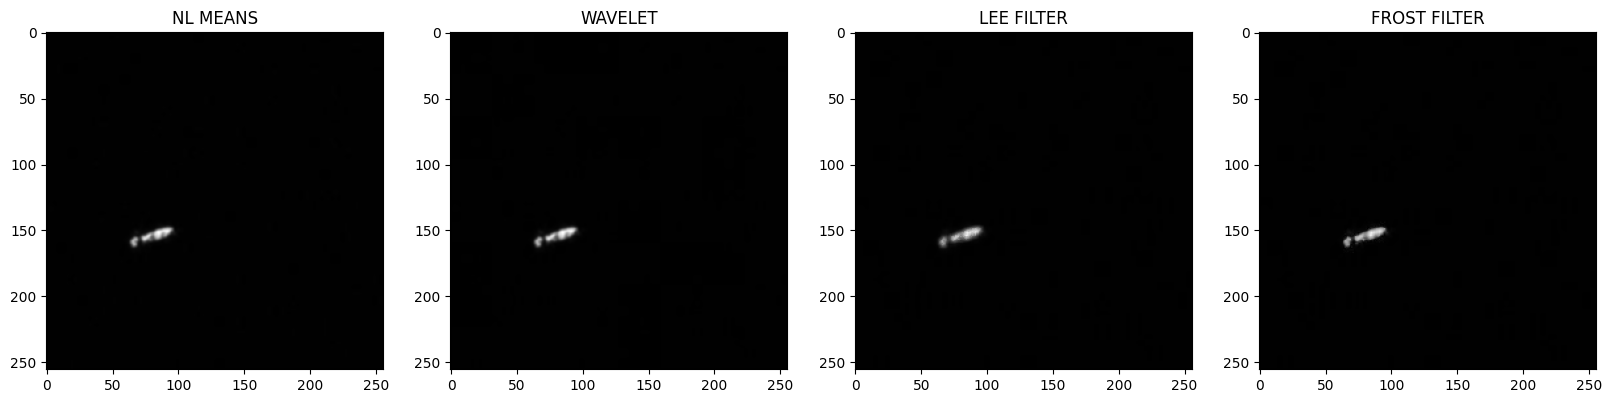

In [11]:
imshow_all(nl_means_img, wavelet_img, lee_img, frost_img, titles=["NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Edge Detection

We now apply the Canny edge detection techniques to show how the above filter methods help in the edge detection task, thanks to the noise removal, compared to the original image. We can also see that here the better results from Lee and Frost filter are more evident.

There are 1 in the image.


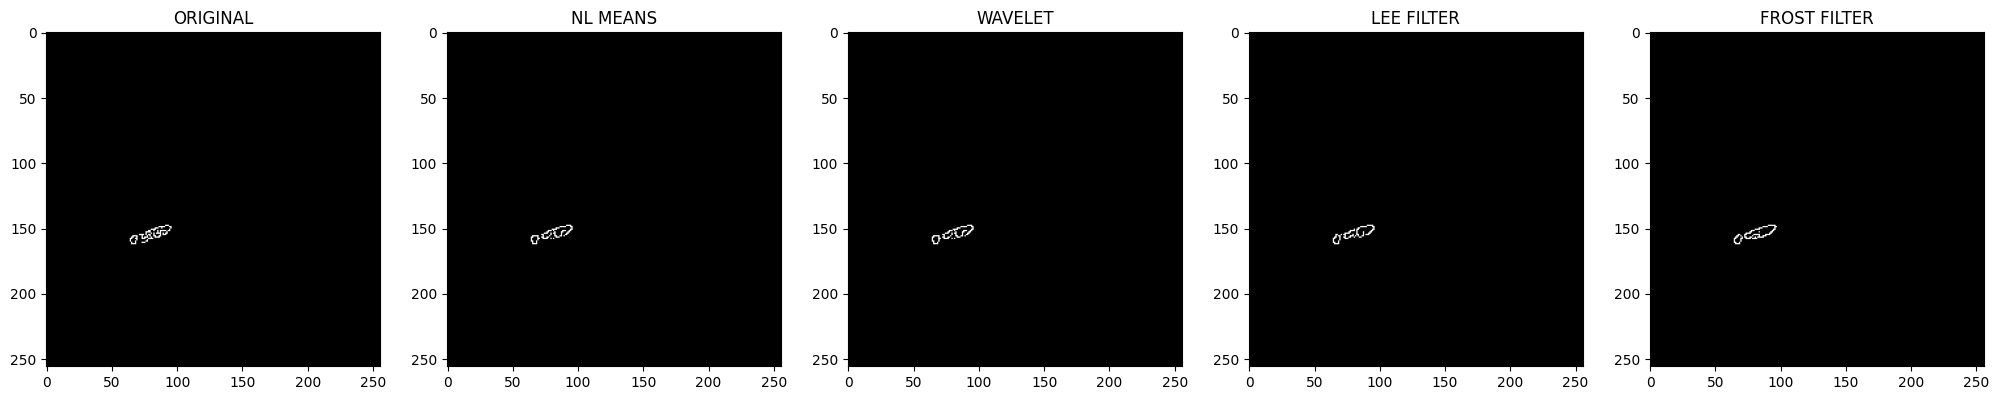

In [13]:
# Edge detection function using Canny method
def canny(img):
    canny_img = cv2.Canny(img, threshold1=100, threshold2=200)
    return canny_img

img = np.uint8(img * 255)
original_canny = canny(img)
nl_means_canny = canny(nl_means_img)
wavelet_canny = canny(wavelet_img)
lee_canny = canny(lee_img)
frost_canny = canny(frost_img)

print(f"There are {ships_cnt} in the image.")

imshow_all(original_canny, nl_means_canny, wavelet_canny, lee_canny, frost_canny, titles=["ORIGINAL", "NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Image Segmentation

Also applying a segmentation techniques is possible to compare better the different filters' outcome and the comparison with the original image.

There are 1 in the image.


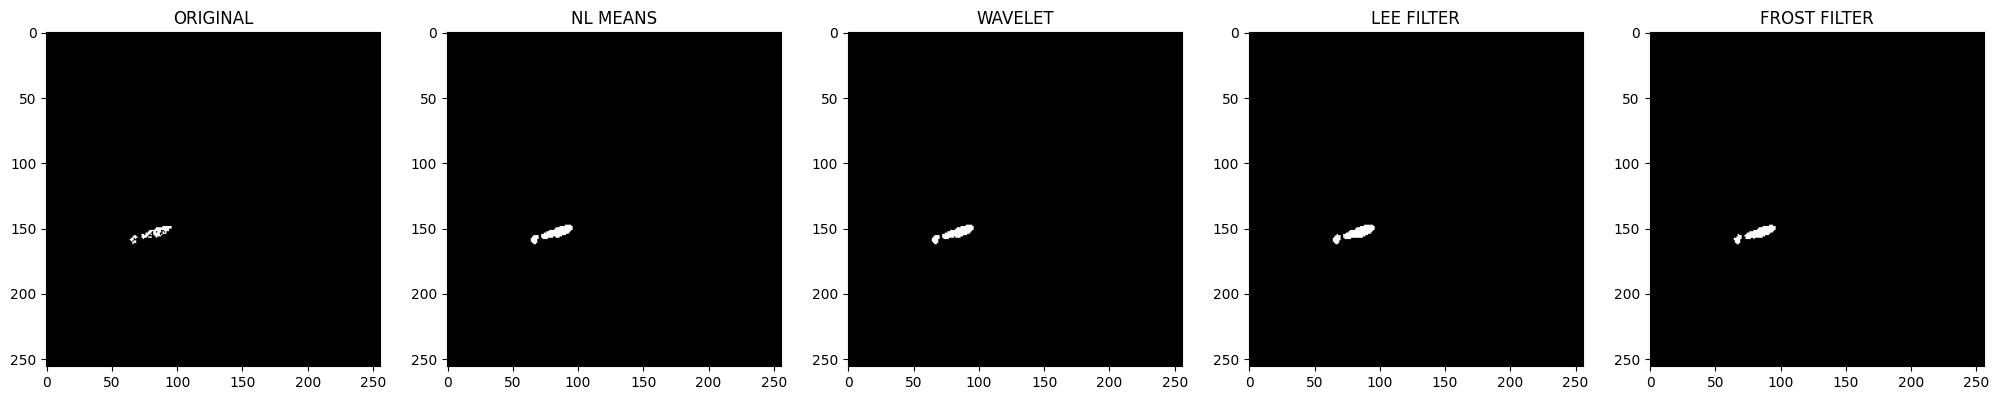

In [14]:
# Apply global thresholding using Otsu's method
def thresholding(img):
    _, thresholded_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresholded_img

thresholded_original = thresholding(img)
thresholded_nl_means = thresholding(nl_means_img)
thresholded_wavelet = thresholding(wavelet_img)
thresholded_lee = thresholding(lee_img)
thresholded_frost = thresholding(frost_img)

print(f"There are {ships_cnt} in the image.")

imshow_all(thresholded_original, thresholded_nl_means, thresholded_wavelet, thresholded_lee, thresholded_frost, 
           titles=["ORIGINAL", "NL MEANS", "WAVELET", "LEE FILTER", "FROST FILTER"])

## Dataset Pre-processing

Here we define the *preprocess_images* function that, given a list of images, a filter and a destination folder name, generates a new folder containing all the filtered images that we will use to train our detection model.

In [15]:
import shutil
from concurrent.futures import ThreadPoolExecutor

def process_image(jpg_file, filter, output_directory):
    img = cv2.imread(jpg_file, cv2.IMREAD_GRAYSCALE)
    float_img = img.astype(np.float64) / 255.0
    new_img = filter(float_img)

    output_path = os.path.join(output_directory, f"{os.path.basename(jpg_file)}")
    cv2.imwrite(output_path, new_img)

def preprocess_images(jpg_files, filter, dir_name, max_workers=10):
    
    output_directory = './' + dir_name + '/'
    if os.path.isdir(output_directory):
        shutil.rmtree(output_directory)
    os.makedirs(output_directory, exist_ok=False)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        
        futures = [executor.submit(process_image, jpg_file, filter, output_directory) for jpg_file in jpg_files]

        for future in futures:
            future.result()

# preprocess_images(jpg_files, nl_means_filter, 'ship_dataset_nlmeansfilter')
# preprocess_images(jpg_files, wavelet_filter, 'ship_dataset_waveletfilter')
# preprocess_images(jpg_files, lee_filter, 'ship_dataset_leefilter')
# preprocess_images(jpg_files, frost_filter, 'ship_dataset_frostfilter')

Here we can zip the filtered images folder if needed.

In [16]:
def zip_folder(folder_path, zip_path):
    if not os.path.exists(folder_path):
        print("The folder path doesn't exist.")
        return

    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_name = os.path.relpath(file_path, folder_path)
                zip_file.write(file_path, arc_name)

folder = './ship_dataset_nlmeansfilter/'

# all images inside, no folder
# zip_folder(folder, folder[:-1]+'.zip')

##  Object Detection using YOLO v8

After performing the pre-processing phase we have set up a ML pipeline in order to split the data, performing the training and finally start the validation phase.
What we expect is to correctly identify ships (one or more than one) by tracing a bounding box around them. 

In order for the experiments to be reproducible in the future we have chosen ClearML as our logger for four reasons:
- it's an open source project
- well documented and offer a good integration with yolov8
- can store model output and help in the comparison between models
- makes the code portable and re-usable in a different machine (control parameters and schedule training directly via we interface)

The data we are working on is very large (almost 80k between images and corresponding labels). Since we are dealing with a lot of data we have decided to use github as our main storage and download and split the data locally when needed. We have seen different providers to store the dataset (such as Roboflow and ClearML) but we exceeded the quota limit for the free tier. If we didn't have labels and we needed to store files Roboflow paid version would have been the go to for completing the project.

#### Note: for running this experiments we suggest colab or a machine with a GPU having at least 6GB of VRAM (if you have less you should modify batch size accordingly)

In order to have a good trade-off between generalization of the model and training speed we have decided to split the data in the following way:

| Training 	| Validation 	| Test 	| Total 	|
|----------	|------------	|------	|-------	|
| 7000     	| 3000       	| 3000 	| 13000 	|

In order to compare the projects we have fixed the images used for each split. We remind that you can find the complete dataset in [this github repo](https://github.com/eboss-dev/SAR-Ship-Dataset) (will be cloned on your machine in the setup phase).

| Dataset name                   	| Size (MB) 	|
|--------------------------------	|-----------	|
| ship_dataset_v0.zip            	| 407       	|
| ship_dataset_leefilter.zip     	| 400       	|
| ship_dataset_nlmeansfilter.zip 	| 421       	|
| ship_dataset_waveletfilter.zip 	| 406       	|

#### PROCESS

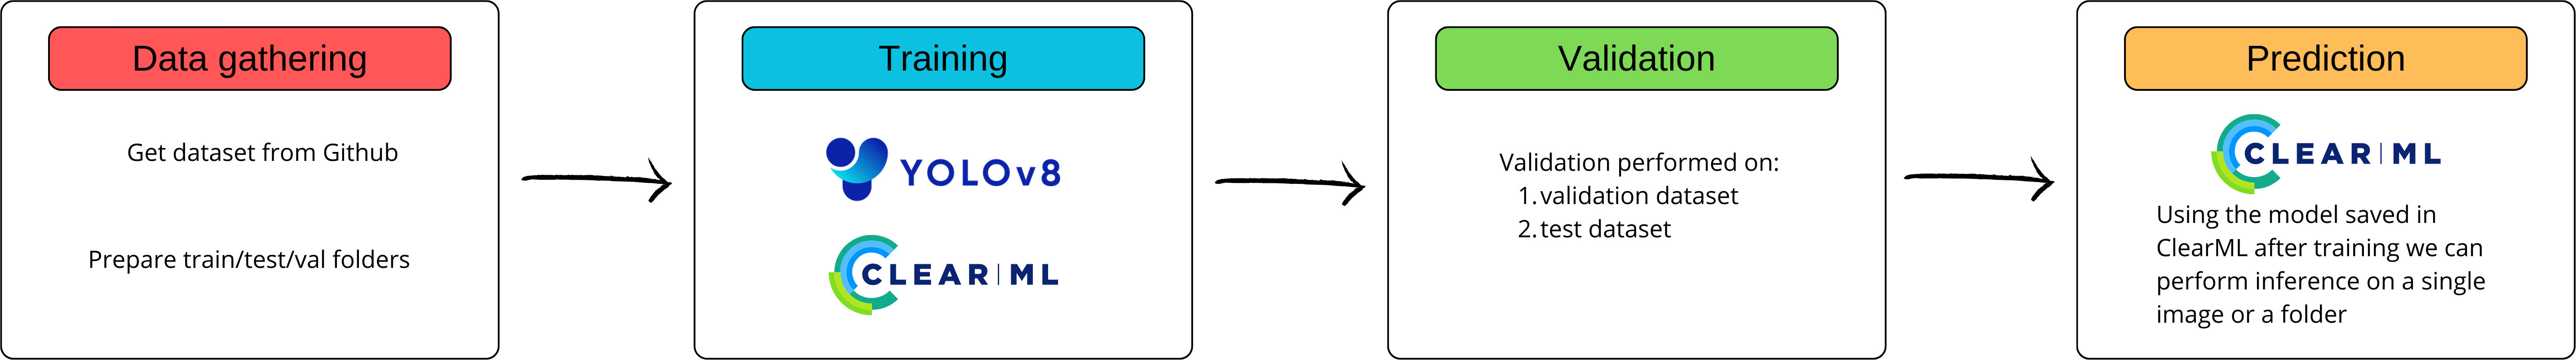


### Setup

In [ ]:
from IPython.display import clear_output

# LIBRARIES TO INSTALL
!pip install ultralytics
clear_output()

In [ ]:
# IMPORTS
from IPython.display import clear_output
import os
import shutil
from ultralytics import YOLO
import random
import locale
from google.colab import files

In [ ]:
clone_repo = 'https://github.com/eboss-dev/SAR-Ship-Dataset'
list_dataset = ['ship_dataset_v0',
                'ship_dataset_leefilter',
                'ship_dataset_nlmeansfilter',
                'ship_dataset_waveletfilter',]
!git clone {clone_repo}

In [ ]:
for to_unzip in list_dataset:
  !unzip ./SAR-Ship-Dataset/{to_unzip}.zip -d ./SAR-Ship-Dataset/
  # Once extracted remove the zip file downloaded from the github repo
  !rm ./SAR-Ship-Dataset/{to_unzip}.zip

clear_output()

In [ ]:
cwd = os.getcwd()
DATASET_PATH = os.join.path(cwd, 'SAR-Ship-Dataset')

def create_folders(image_path, label_path):
  try:
    os.makedirs(image_path)
    os.makedirs(label_path)
    return 1
  except Exception as e:
    print(f'Some error occured: {e}')
    return 0

# create train, test, valid and add the images and labels
def copy_in_new_folder(split, list_img):
  IMAGE_SPLIT_PATH = os.path.join(DATASET_PATH, folder, split, 'images')
  LABEL_SPLIT_PATH = os.path.join(DATASET_PATH, folder, split, 'labels')

  if(create_folders(IMAGE_SPLIT_PATH, LABEL_SPLIT_PATH)):
    for img in list_img:
      img = img.strip()
      shutil.move(os.path.join(DATASET_PATH, folder, img),  # FROM SOURCE
                  os.path.join(IMAGE_SPLIT_PATH, img))      # TO SPLIT PATH
      shutil.move(os.path.join(DATASET_PATH, folder, img[:-4]+'.txt'),
                os.path.join(LABEL_SPLIT_PATH, img[:-4]+'.txt'))

def delete_unnecessary(folder):
  _, _, files_list = next(os.walk(folder))

  for file in files_list:
    if(file.endswith('.txt') or file.endswith('.jpg')):
      os.remove(os.path.join(DATASET_PATH, folder, file))

def prepare_data_for_training():
  for dataset in list_dataset:

    folder = 'ship_dataset_'+ds_name

    # 1 - copy train
    with open(os.join.path(DATASET_PATH, 'train_images.txt'), 'r') as file:
        # Read all lines into a list
        lines = file.readlines()
    copy_in_new_folder('train', lines)

    # 2 - copy validation
    with open(os.join.path(DATASET_PATH, 'validation_images.txt', 'r') as file:
        # Read all lines into a list
        lines = file.readlines()
    copy_in_new_folder('validation', lines)

    # 3 - copy test
    with open(os.join.path(DATASET_PATH, 'test_images.txt', 'r') as file:
        # Read all lines into a list
        lines = file.readlines()
    copy_in_new_folder('test', lines)

    # 4 - delete other files
    delete_unnecessary(os.path.join(DATASET_PATH, folder))

    print(f'✅ Dataset {folder} ready for training, validation and test!')

In [ ]:
prepare_data_for_training()

### Training part

#### Pure dataset training

In [ ]:
# we use this constructor to create a new model
# We can also use old models in order to perform trasfer learning and lessen
# the actual training time
model_v0 = YOLO()

v0_yaml = os.path.join(cwd, 'SAR-Ship-Dataset', 'data_v0.yaml')

# data.yaml is downloaded from the github repo
train_v0 = model_v0.train(data=v0_yaml, epochs=100, imgsz=256) #train the model

#### Preprocessed dataset Leefilter

In [ ]:
model_leefilter = YOLO()

model_leefilter_yaml = os.path.join(cwd, 'SAR-Ship-Dataset', 'data_leefilter.yaml')

# data.yaml is downloaded from the github repo
train_model_leefilter = model_leefilter.train(
    data=model_leefilter_yaml, epochs=100, imgsz=256, batch=256)

#### Preprocessed dataset Nlmeansfilter

In [ ]:
model_nlmeansfilter = YOLO()

model_nlmeansfilter_yaml = os.path.join(cwd, 'SAR-Ship-Dataset', 'data_nlmeansfilter.yaml')

# data.yaml is downloaded from the github repo
train_model_nlmeansfilter = model_nlmeansfilter.train(
    data=model_nlmeansfilter_yaml, epochs=100, imgsz=256, batch=256)

#### Preprocessed dataset Waveletfilter

In [ ]:
model_waveletfilter = YOLO()

model_waveletfilter_yaml = os.path.join(cwd, 'SAR-Ship-Dataset', 'data_waveletfilter.yaml')

# data.yaml is downloaded from the github repo
train_model_waveletfilter = model_waveletfilter.train(
    data=model_waveletfilter_yaml, epochs=100, imgsz=256, batch=256)

### Validation on seen and unseen data

In [ ]:
def validation_val_test(model):
    model.val(save_json = True, split='val',  batch=256)
    model.val(save_json = True, split='test', batch=256)

In [ ]:
validation_val_test(model_v0)

In [ ]:
validation_val_test(model_leefilter)

In [ ]:
validation_val_test(model_nlmeansfilter)

In [ ]:
validation_val_test(model_waveletfilter)

### Predict on new data

In [ ]:
# This is used for having a prediction on new data
# It is not mandatory but useful to test inference on new data
# In this we can extract from the model the actual folder where the weights
# are saved for retriving the best or use clearml to run inference
'''
model = YOLO(PROJECT_LOC+"best.pt") # random best da cambiare con il training approfondito
results = model.predict(
    source    = PROJECT_LOC+"test_images",
    conf      = 0.5,  # confidence > 50%
    #save      = True, # this will save the images with annotation in /runs/detect/predict/file_name.xyz
    save_txt  = True, # this will save the actual labels in /runs/detect/predict/labels/<original_file_name>.txt
    imgsz     = 256)
'''

## RESULTS

### Train metrics

#### Train summary

| Name          	| model/parameters 	| model/GFLOPs 	| model/speed_PyTorch(ms) 	| metrics/precision 	| metrics/recall 	| metrics/mAP50 	| metrics/mAP50-95 	| fitness 	|
|---------------	|------------------	|--------------	|-------------------------	|-------------------	|----------------	|---------------	|------------------	|---------	|
| Original data 	| 3011043          	| 8.194        	| 0.616                   	| 0.9066 ❄         	| 0.8778 ❄         	| 0.9330 ❄        	| 0.5626 ❄           	| 0.5996 ❄  	|
| Leefilter 🌟     	| 3011043          	| 8.194        	| 0.613 🔥                  	| 0.9148 🔥            	| 0.9007 🔥         	| 0.9439 🔥        	| 0.5790 🔥           	| 0.6155 🔥  	|
| Nlmeansfilter 	| 3011043          	| 8.194        	| 0.641                   	| 0.9108            	| 0.8968         	| 0.9436        	| 0.5785           	| 0.6150  	|
| Waveletfilter 	| 3011043          	| 8.194        	| 0.708 ❄                 	| 0.9112            	| 0.8887         	| 0.9388        	| 0.5655           	| 0.6029  	|


<div>
  <iframe
    src="https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=23eeaa760ab24d7a80ded8ebeaa61ae3&metrics=metrics&variants=mAP50(B)&variants=mAP50-95(B)&variants=precision(B)&variants=recall(B)&light=true&company=55686978e85b40e9913759602abdcde2"
    width="24%" height="400"
  ></iframe>
  <iframe
    src="https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=9a85b9a894504d29b93b5c49e491657a&metrics=metrics&variants=mAP50(B)&variants=mAP50-95(B)&variants=precision(B)&variants=recall(B)&light=true&company=55686978e85b40e9913759602abdcde2"
    width="24%" height="400"
  ></iframe>
  <iframe
    src="https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=f3934725cb314c7fba99f72a4da9f11e&metrics=metrics&variants=mAP50(B)&variants=mAP50-95(B)&variants=precision(B)&variants=recall(B)&light=true&company=55686978e85b40e9913759602abdcde2"
    width="24%" height="400"
  ></iframe>
  <iframe
    src=https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=c467a57107ae4d4ca6f334daffdff2d5&metrics=metrics&variants=mAP50(B)&variants=mAP50-95(B)&variants=precision(B)&variants=recall(B)&light=true&company=55686978e85b40e9913759602abdcde2
    width="24%" height="400"
  ></iframe>
<div>

#### Training validation

<div>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=23eeaa760ab24d7a80ded8ebeaa61ae3&metrics=val&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=metrics%2FmAP50(B)&variants=metrics%2FmAP50-95(B)&variants=metrics%2Fprecision(B)&variants=metrics%2Frecall(B)&variants=val%2Fbox_loss&variants=val%2Fcls_loss&variants=val%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="500"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=9a85b9a894504d29b93b5c49e491657a&metrics=val&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=metrics%2FmAP50(B)&variants=metrics%2FmAP50-95(B)&variants=metrics%2Fprecision(B)&variants=metrics%2Frecall(B)&variants=val%2Fbox_loss&variants=val%2Fcls_loss&variants=val%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="500"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=f3934725cb314c7fba99f72a4da9f11e&metrics=val&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=metrics%2FmAP50(B)&variants=metrics%2FmAP50-95(B)&variants=metrics%2Fprecision(B)&variants=metrics%2Frecall(B)&variants=val%2Fbox_loss&variants=val%2Fcls_loss&variants=val%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="500"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=c467a57107ae4d4ca6f334daffdff2d5&metrics=val&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=metrics%2FmAP50(B)&variants=metrics%2FmAP50-95(B)&variants=metrics%2Fprecision(B)&variants=metrics%2Frecall(B)&variants=val%2Fbox_loss&variants=val%2Fcls_loss&variants=val%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="500"
  ></iframe>
</div>

#### Box Loss

<div>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=23eeaa760ab24d7a80ded8ebeaa61ae3&metrics=train&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=train%2Fbox_loss&variants=train%2Fcls_loss&variants=train%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=9a85b9a894504d29b93b5c49e491657a&metrics=train&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=train%2Fbox_loss&variants=train%2Fcls_loss&variants=train%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=f3934725cb314c7fba99f72a4da9f11e&metrics=train&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=train%2Fbox_loss&variants=train%2Fcls_loss&variants=train%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=scalar&objectType=task&xaxis=iter&objects=c467a57107ae4d4ca6f334daffdff2d5&metrics=train&variants=box_loss&variants=cls_loss&variants=dfl_loss&variants=train%2Fbox_loss&variants=train%2Fcls_loss&variants=train%2Fdfl_loss&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
</div>

#### Confusion matrix

<style>
  #container {
    display: flex;
    justify-content: space-between;
}
</style>
<div id="container">
  <div width="24%"> Original dataset </div>
  <div width="24%"> Leefilter dataset </div>
  <div width="24%"> Nlmeansfilter dataset </div>
  <div width="24%"> Waveletfilter dataset </div>
</div>
<br>
<div>
  <iframe
    src='https://embed.clear.ml/widgets/?type=plot&objectType=task&objects=23eeaa760ab24d7a80ded8ebeaa61ae3&metrics=confusion_matrix&variants=plot%20image&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=plot&objectType=task&objects=9a85b9a894504d29b93b5c49e491657a&metrics=confusion_matrix&variants=plot%20image&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=plot&objectType=task&objects=f3934725cb314c7fba99f72a4da9f11e&metrics=confusion_matrix&variants=plot%20image&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
  <iframe
    src='https://embed.clear.ml/widgets/?type=plot&objectType=task&objects=c467a57107ae4d4ca6f334daffdff2d5&metrics=confusion_matrix&variants=plot%20image&light=true&company=55686978e85b40e9913759602abdcde2'
    width="24%" height="400"
  ></iframe>
</div>

### Validation on test data (unseen images)

| name             | mAP50-95 | mAP50   | Precision | Recal  |
|------------------|----------|---------|-----------|--------|
| Original dataset | 0.5629   | 0.93452 | 0.9139    | 0.8838 |
| Leefilter        | 0.5821   | 0.9457  | 0.9307    | 0.8851 |
| Nlmeansfilter    | 0.5792   | 0.9399  | 0.9132    | 0.8901 |
| Waveletfilter    | 0.5726   | 0.9420  | 0.91482   | 0.8919 |

<!--
name,mAP50-95,mAP50,Precision,Recal
Original dataset,0.5629293052488276,0.9345349479209902,0.9133581688441329,0.8838130446263534
Leefilter,0.5821709247355775,0.9457292649618841,0.9307598742726667,0.8851333509374175
Nlmeansfilter,0.5792299134049966,0.9399731411104622,0.9132441520906397,0.8901505149194613
Waveletfilter,0.5726206970375366,0.9420000520102989,0.9148975968922682,0.8919989437549511-->


<h3> Original dataset (ground truth left | prediction right) </h3>
<img src="./images/v0 validation/Validation_val_labels.jpg_00000000.jpg" width="49%" >
<img src="./images/v0 validation/Validation_val_pred.jpg_00000000.jpg" width="49%">

<h3> Leefilter (ground truth left | prediction right)  </h3>
<img src="./images/leefilter validation/Validation_val_labels.jpg_00000000.jpg" width="49%" >
<img src="./images/leefilter validation/Validation_val_pred.jpg_00000000.jpg" width="49%">

<h3> Nlmeansfilter (ground truth left | prediction right)  </h3>
<img src="./images/nlmeansfilter validation/Validation_val_labels.jpg_00000000.jpg" width="49%" >
<img src="./images/nlmeansfilter validation/Validation_val_pred.jpg_00000000.jpg" width="49%">

<h3> Waveletfilter (ground truth left | prediction right)  </h3>
<img src="./images/waveletfilter validation/Validation_val_labels.jpg_00000000.jpg" width="49%" >
<img src="./images/waveletfilter validation/Validation_val_pred.jpg_00000000.jpg" width="49%">


### Conclusion

We trained the model using 7,000 images, and although we didn't utilize the entire dataset, it proved sufficient to obtain effective weights. We opted for this specific split to prioritize shorter training times over the model's generalization capabilities. Each model took approximately 1 hour and 20 minutes to train.

The robustness of the training is confirmed during validation on previously unseen data. Our obtained values closely match the validation results on the training data. Across all preprocessing techniques employed, our model consistently performed better than the original.

We can affirm that the "leefilter" stands out as the best among the analyzed filters.

### Potential improvement

Improvements can be made by tuning the hyperparameters of the pretrained model. By adjusting the weights we are expecting to find a better accuracy.<br>Transfer learning can help in saving compute time. We can add new data and train with a previously trained model to obtain (hoperfully) a better model.

## *Resources*

* OpenCV documentation: https://docs.opencv.org/4.x/
* Scikit-image documentation: https://scikit-image.org/docs/stable/
* YOLOv8 documentation: https://docs.ultralytics.com
* CleaML documentation: https://clear.ml/docs/latest/docs/
* P. Kaushik and S. Jabin, "A Comparative study of Pre-processing Techniques of SAR Images," 2018 4th International Conference on Computing Communication and Automation (ICCCA), Greater Noida, India, 2018, pp. 1-4, doi: 10.1109/CCAA.2018.8777710.
* Antoni Buades, Bartomeu Coll, and Jean-Michel Morel, Non-Local Means Denoising, Image Processing On Line, 1 (2011), pp. 208–212. https://doi.org/10.5201/ipol.2011.bcm_nlm
* Singh, P., Diwakar, M., Shankar, A. et al. A Review on SAR Image and its Despeckling. Arch Computat Methods Eng 28, 4633–4653 (2021). https://doi.org/10.1007/s11831-021-09548-z
* S. Wei, X. Zeng, Q. Qu, M. Wang, H. Su and J. Shi, "HRSID: A High-Resolution SAR Images Dataset for Ship Detection and Instance Segmentation," in IEEE Access, vol. 8, pp. 120234-120254, 2020, doi: 10.1109/ACCESS.2020.3005861.
* J. Terven, D. M. Córdova-Esparza, "A Comprehensive Review of YOLO Architectures in Computer Vision: from YOLOv1 to YOLOv8 and YOLO-NAS", (2023) https://doi.org/10.3390/make5040083